In [184]:
#https://github.com/bradkav/WIMpy_NREFT
from WIMpy import DMUtils as DMU

In [185]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from scipy.integrate import quad
from scipy.integrate import simpson
from scipy.integrate import cumtrapz
from scipy.integrate import trapezoid
from scipy.optimize import minimize
from scipy.stats import rv_continuous
import time

# Ionization and Nuclear recoil Energy

The energy from a DM-nucleus interaction is the nuclear recoil energy. However, this energy is not directly measured in the DAMIC CCDs. This nuclear recoil of DM with the silicon of the CCDs pixels generates a certain number of pair electron-holes. The energy of this pairs is the ionization energy. The relation between this two energies is given a Lindhard Model in https://arxiv.org/pdf/1608.00957.pdf.

In [186]:
##To avoid RuntimeWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

def lindhard(E):
    ep = E*10.5/np.power(14,7/3)
    g = 0.0100686*np.power(ep,-0.02907) + 0.0100686*np.power(ep,-0.02907) + ep
    fact = 2.81961*g/(1.+2.81961*g)
    return E*fact

The linhard model gives the ionization energy given a nuclear recoil. Sometimes is useful to obtain the nuclear recoil from the ionization energy. This is obtained from the inverse of the lindhard model.

In [187]:
from pynverse import inversefunc

def lindhard_inv(Ee):
    return inversefunc(lindhard, y_values = Ee).astype(float)

The derivative of the lindhard model will be useful for the chain rule of some derivatives. The inverse derivative it's just the inverse of the derivative value

In [188]:
from scipy.misc import derivative

def linhard_derivative(E):
    ### E in nuclear recoil
    return derivative(lindhard, E, dx=1e-6)

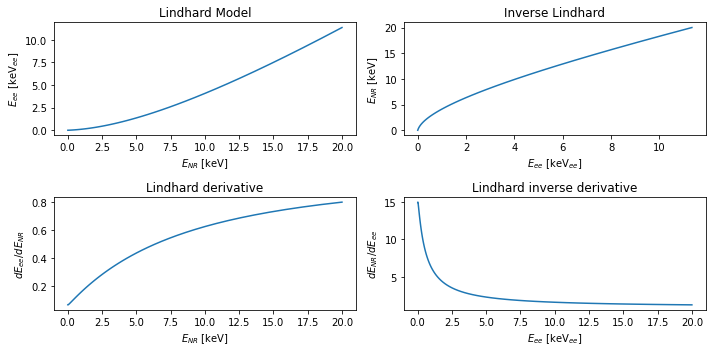

In [189]:
Enr = np.geomspace(1e-2, 20, 100) #nuclear recoil energies in keV

#Lindhard model
Eee = lindhard(Enr) #ionization energy in KeVee
fig, ax = plt.subplots(2,2)
ax[0,0].plot(Enr, Eee)
ax[0,0].set_xlabel(r"$E_{NR}$ [keV]")
ax[0,0].set_ylabel(r"$E_{ee}$ [keV$_{ee}$]")
ax[0,0].set_title("Lindhard Model")

#Linhard inverse
Enr_inv = lindhard_inv(Eee)
ax[0,1].plot(Eee,Enr_inv)
ax[0,1].set_ylabel(r"$E_{NR}$ [keV]")
ax[0,1].set_xlabel(r"$E_{ee}$ [keV$_{ee}$]")
ax[0,1].set_title("Inverse Lindhard")

#Linhard derivative
dEr_dEe = linhard_derivative(Enr)
ax[1,0].plot(Enr, dEr_dEe)
ax[1,0].set_ylabel(r"$dE_{ee}/dE_{NR}$ ")
ax[1,0].set_xlabel(r"$E_{NR}$ [keV]")
ax[1,0].set_title("Lindhard derivative")

#Linhard inverse derivative
dEe_dEr = 1/dEr_dEe
ax[1,1].plot(Enr, dEe_dEr)
ax[1,1].set_ylabel(r"$dE_{NR}/dE_{ee}$ ")
ax[1,1].set_xlabel(r"$E_{ee}$ [keV$_{ee}$]")
ax[1,1].set_title("Lindhard inverse derivative")

fig.tight_layout()
plt.show()

We want to know the expected event rate per kg of detector per day of signals. This rate will depend on the Energy of the nuclear recoils and is obtained from the Bradley's code.

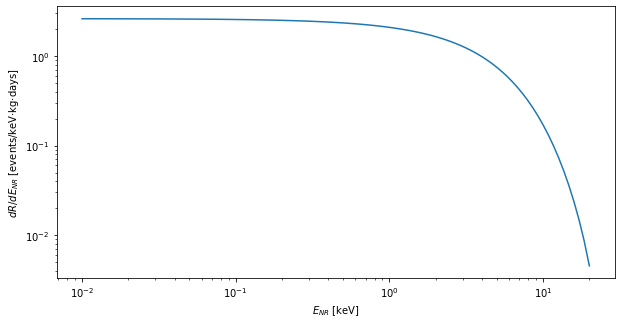

In [190]:
#Properties of Silicon
N_p_Si, N_n_Si = 14, 14
#Properties of DM
mx, sigma = 10, 1e-40 #GeV, cm2
#Differential rate of events
dRdEr = DMU.dRdE_standard(Enr, N_p_Si, N_n_Si, mx, sigma)
plt.loglog(Enr, dRdEr)
plt.xlabel(r"$E_{NR}$ [keV]")
plt.ylabel(r"$dR/dE_{NR}$ [events/keV$\cdot$kg$\cdot$days]")
plt.show()

The measured quantity in a CCD is the ionization energy. We need to transform this rate from energy recoils to ionization energy. The experiment will also have a signal detection efficiency and an energy resolution which is gaussian. 

$$
    \frac{dR}{dE_{ee}} = \epsilon(E_{ee})\int_{E_{ee}^{min}}^{E_{ee}^{max}}\frac{dR(E_{NR},M,\sigma_{p})}{dE_{NR}} \cdot  \left|\frac{dE_{NR}}{dE_{ee}}\right|  \cdot G(E-E_{ee}|\sigma_{ee})\cdot dE
$$

But this is equivalent changing the variable of the integral from ionization energy to nuclear recoils.

$$
    \frac{dR}{dE_{ee}} = \epsilon(E_{ee})\int_{E_{NR}^{min}}^{E_{NR}^{max}}\frac{dR(E_{NR},M,\sigma_{p})}{dE_{NR}} \cdot G(E'-E_{NR}|\sigma_{NR})\cdot dE'
$$

We are using.
* Energy resolution $\sigma_{ee} = 4$ eV$_{ee}$.
* Efficiency is $\epsilon(E) = 0 $ if $x\leq4$ eV$_{ee}$ and $0.75$ if $x>4$ eV$_{ee}$

In [191]:
def efficiency(E):
    if E <= 0.004:
        return 0   #Set efficiency to zero below 8 eV
    else:
        return 0.75
    
    
def resolution(E1, E2, sigma_E):
    ## E1 is the energy point of the gaussian.
    ## E2 is the center energy of the gaussian.
    #sigma_E = 4e-3 # 4 eV of resolution for DAMIC-M
    #print(E1.T[0])
    #print(E2)
    #print(E2-E1.T[0])
    deltaE = (E1.T-E2)
    #print(deltaE)
    #gaus = (2*np.pi*sigma_E**2)**-0.5*np.exp(-0.5*(deltaE.T)**2/sigma_E**2)
    #plt.plot(deltaE.T, gaus)
    return (2*np.pi*sigma_E**2)**-0.5*np.exp(-0.5*(deltaE.T)**2/sigma_E**2)



def dR_dEe(Er, N_p_Si, N_n_Si, m_x, sigma_p):
    """ Calculates the rate at the energy point Er.
        Er must have nuclear recoil units.
        The integral is performed in nuclear recoil units.
    """
    ### Conversion things
    original_type = False
    if type(Er) is not np.ndarray:
        if type(Er) is not list:
            original_type = True
            Er = [Er]
        Er = np.array(Er)
    ### Energy recoil units are given
    sigma_Ee = 4e-3 # 4 eV of resolution for DAMIC-M
    sigma_Er = lindhard_inv(sigma_Ee)
    Ee = lindhard(Er)
    ## Integral limits in energy recoil units
    Emin, Emax = np.clip(Er-5*sigma_Er,sigma_Er,100), np.clip(Er+5*sigma_Er,sigma_Er,100)
    ### To increase the speed-> if eff = 0. We dont calculate the integral.
    eff = 0.75
    ### Sigma region of energies for each point in Er
    E_space = np.geomspace(Emin, Emax, 100).T
    ### Calculates the integrand for each point
    integrand = DMU.dRdE_standard(E_space, N_p_Si, N_n_Si, m_x, sigma_p)*resolution(E_space,Er,sigma_Er)
    ### Integrates each point over its sigma interval 
    dR = eff*simpson(integrand,E_space)
    ### Efficiency cut
    dR[Er<=sigma_Ee] = np.zeros([len(Er[Er<=sigma_Ee])])
    #print(integrand.shape)
    #ind = 98
    #plt.loglog(E_space[ind], integrand[ind], alpha = 0.1)
    #plt.loglog(Er,DMU.dRdE_standard(Er, N_p_Si, N_n_Si, m_x, sigma_p), alpha = 0.1,linewidth=2)
    #plt.xlim([0.1,1])
    #plt.show()
    #print(dR)
    #plt.plot(Er, dR)
    if original_type:
        dR = np.float64(dR)
    return dR


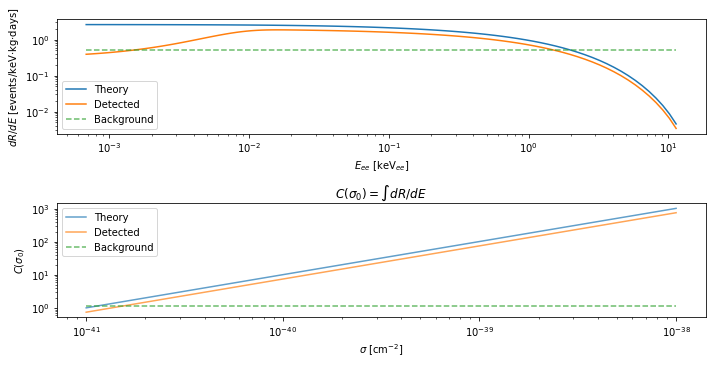

In [192]:
dR_dE = np.array([dR_dEe(E, N_p_Si, N_n_Si, mx, sigma) for E in Enr])
fig, ax = plt.subplots(2,1)

ax[0].loglog(Eee, dRdEr, label = "Theory")
ax[0].loglog(Eee, dR_dE, label = "Detected")
ax[0].loglog(Eee, [0.5] * len(dR_dE), '--', alpha= 0.7, label = "Background")
ax[0].set_xlabel(r"$E_{ee}$ [keV$_{ee}$]")
ax[0].set_ylabel(r"$dR/dE$ [events/keV$\cdot$kg$\cdot$days]")
ax[0].legend(loc="best")


## Detected Constant
xsmin,xsmax, xsnum = -41, -38, 5
xs = np.linspace(xsmin,xsmax, xsnum)
#cee = [quad(dR_dEe, Enr[0],Enr[-1], args=(N_p_Si, N_n_Si,mx,10 ** s),epsabs=1e-6)[0] for s in xs]
cee = [simpson(dR_dEe(Enr, N_p_Si, N_n_Si,mx,10 ** s),Enr) for s in xs]

c = [quad(DMU.dRdE_standard, Enr[0],Enr[-1], args=(N_p_Si, N_n_Si,mx,10 ** s),epsabs=1e-6)[0] for s in xs]
cb = [quad(lambda x: 0.1, Eee[0],Eee[-1], epsabs=1e-8)[0] for s in xs]


ax[1].loglog(np.power(10,xs), c, alpha = 0.7, label = "Theory")
ax[1].loglog(np.power(10,xs), cee, alpha = 0.7, label = "Detected")
ax[1].loglog(np.power(10,xs), cb, '--', alpha = 0.7, label = "Background")
ax[1].set_xscale("log")
ax[1].set_ylabel(r"$C(\sigma_0)$")
ax[1].set_xlabel(r'$\sigma$ [cm$^{-2}$]')
ax[1].set_title("$C(\sigma_0)=\int dR/dE$")
ax[1].legend(loc="best")

fig.tight_layout()
plt.show()

This will be the detected signal spectrum on our CCD. Now we need to calculate the probabilty of obtaining a number of signals at a certain energy. This probability is the different rate per ionization energy divided by a constant that makes the integral over the range of energy equal to 1.

# Likelihood

We now need to calculate the likelihood. The energy in the fiducial region will be between 8eVee and 7keVee. The likelihood is given in https://arxiv.org/pdf/1607.07410.pdf.

$$
L(s,M|E) = e^{-s}\prod_{i}^{N} s\cdot f_s(E_i|M)
$$

Where $s= t_{expo}\cdot m_{det} \cdot \int_{fiducial}dR(\sigma_0)/dE_{ee}$ (expecter number of events for the given cross section). The $e^{-s}$ accounts the poissonian probability of having the given number of events with the expected number of events $Pois(N|s)$ as $\prod s= s^{N}$. And $f_s(E_i|M)$ is the PDF of the signal given by

$$
f_s(E|M) = \frac{1}{C(\sigma_0)}\frac{dR}{dE_{ee}}
$$

Where $dR/dE_{ee}$ is the detection differential rate and $C(\sigma_0)=\int_{fiducial}dR(\sigma_0)/dE_{ee}$ is the integral of the detection differential rate in the fiducial region.

We need to find the maximum likelihood but we have and algorithm to find the minimum of a function. We just need to calculate the negative likelihood. Also it's easier to compute the negative log-likelihood.

$$
-ln|L(s,M|E)| = s - \sum_i^N ln|s \cdot f_s(E_i|M)|
$$


If we add a PDF for background the log-likelihood will be

$$
-ln|L(s,M|E)| = (s+b) - \sum_i^N ln|s \cdot f_s(E_i|M) + b \cdot f_b(E_i|M)|
$$

We will suppose a flat background distribution. The PDF in the fiducial region is given by

$$
f_b(E|M) = \epsilon_{Bkg}(E_{ee})\frac{1}{\Delta E}
$$

Where $b = N_{events}^{bkg}\cdot t_{expo}\cdot m_{det}$ and $R_{bkg}$ doesn't depend on energy. Where $\epsilon_{Bkg}(E_{ee}) = 0.5, E_{ee} > 8$ eV$_{ee}$ and $\epsilon_{Bkg}(E_{ee}) = 0, E_{ee} \leq 8$ eV$_{ee}$.


In [229]:
def log_likelihood(theta,Er,Ermin,Ermax, N_p_Si, N_n_Si, m_x,texp_mass,detection=False, background=False):
    """ Calculates the log likelihood of the given Events signals Er.
        Er must be in Nuclear recoil units.
        The loglikelihood can be the theoretical (returning in nuclear recoil units)
        or the detected (returning in Eee units).
        Background can also be added.
    """
    
    ### Converts list into array
    if type(Er) is list:
        Er = np.array(Er)
    ### Fitting parameters
    if background:
        sigma_exp, b = theta
    else:
        sigma_exp = theta
        
    sigma_p = np.power(10, sigma_exp)
    
    Enr_space = np.geomspace(Ermin,Ermax,100)
    
    if detection:
        #dR = np.array([dR_dEe(E, N_p_Si, N_n_Si, m_x, sigma_p) for E in Er])
        dR = dR_dEe(Er, N_p_Si, N_n_Si, m_x, sigma_p)
        #dR_space = [dR_dEe(E, N_p_Si, N_n_Si, m_x, sigma_p) for E in Enr_space]
        dR_space = dR_dEe(Enr_space, N_p_Si, N_n_Si, m_x, sigma_p)
        C_sigma0 = simpson(dR_space,lindhard(Enr_space))
    else:
        dR = DMU.dRdE_standard(Er, N_p_Si, N_n_Si, m_x, sigma_p)
        #C_sigma0 = quad(DMU.dRdE_standard, Ermin,Ermax, args=(N_p_Si, N_n_Si,m_x,sigma_p),epsrel=1e-6)[0]
        dR_space = DMU.dRdE_standard(Enr_space, N_p_Si, N_n_Si, m_x, sigma_p) 
        C_sigma0 = simpson(dR_space,Enr_space)
        
    ### PDF signal and expected signal events
    fs  = dR/C_sigma0
    ## Expected signal events
    s = C_sigma0*texp_mass
    if background:
        ### Adds background
        dEee = lindhard(Ermax)-lindhard(Ermin)
        ## Calculates the number of events above the efficiency threshold
        # En teoria deberian ser todos si esta bien simulado¿
        fb = np.zeros([len(Er)])
        Er_eff = np.array(Er)[np.array(Er)>lindhard_inv(0.004*2)]
        fb[np.array(Er)>lindhard_inv(0.004*2)] = [1/dEee] * len(Er_eff)
        fb[np.array(Er)<=lindhard_inv(0.004*2)] = [0] * (len(Er)-len(Er_eff))
        ### log likelihood
        _lnL = (s+b) - np.sum( np.log(s*fs + b*fb) )
    else:
        ### log likelihood
        _lnL = s - np.sum(np.log(s*fs))        
    return _lnL

# Simulate signal

We now need to simulate a signal in order to see if we obtain the number expected from the likelihood. The number of expected events will be 

$$
s = t_{expo}\cdot m_{detector} \cdot \int_{E_{ee}^{min}}^{E_{ee}^{max}} \frac{dR}{dE_{ee}} \cdot dE_{ee}
$$

Number of theoretical events:  69.71214766936787
Number of expected events:  3.0860254240457348
Number of detected events:  67


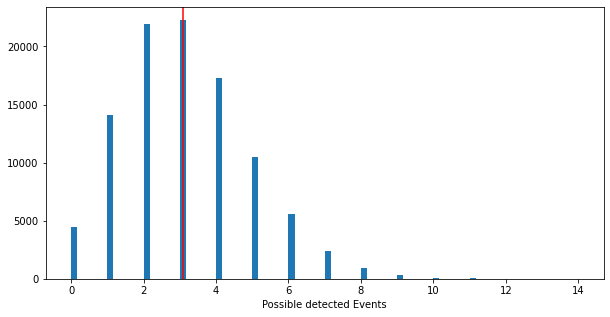

In [230]:
np.random.seed(42)

mass_det = 1 #kg
expo_det = 5 #days
cross_section = 6e-40 #cm2
mass_dm = 1 #GeV
Eemin, Eemax = 4e-3, 7 #keV limits of fiducial region
Ermin, Ermax = lindhard_inv(Eemin) , lindhard_inv(Eemax) 

### Normalization
Enr_space = np.geomspace(Ermin,Ermax,100)
dRdEe_ev = dR_dEe(Enr_space,N_p_Si, N_n_Si,mass_dm, cross_section)
C_sig = trapezoid(dRdEe_ev, lindhard(Enr_space))

#print(C_sig)
#dRdEe_der = [dR_dEe(E,N_p_Si, N_n_Si,mass_dm, cross_section)*linhard_derivative(E) for E in Enr_space]
#print(trapezoid(dRdEe_der, Enr_space))
#dRder = lambda E, p: dR_dEe(E,*p)*linhard_derivative(E)
#C_sig_quad = quad(dRder, Ermin, Ermax, args=([N_p_Si, N_n_Si,mass_dm, cross_section]),epsabs=1e-20)[0]
#print(C_sig_quad)
#print(C_sig)
#print("Difference quad-simpson: ", C_sig_quad-C_sig)

### Number of events is mass*expo*integral(dRdE)
s = mass_det*expo_det*C_sig
### Theoretical
C_sig_theo = simpson(DMU.dRdE_standard(Enr_space,N_p_Si, N_n_Si,mass_dm,cross_section),Enr_space)
#print(C_sig_theo)
s_theo = mass_det*expo_det*C_sig_theo
s_theo_quad = mass_det*expo_det*quad(DMU.dRdE_standard, Ermin,Ermax, args=(N_p_Si, N_n_Si,mass_dm,cross_section),epsabs=1e-20)[0]
#print(s_theo_quad)
#print(s_theo)

print("Number of theoretical events: ", s_theo)
print("Number of expected events: ", s)
n_det = np.random.poisson(s_theo)
print("Number of detected events: ", n_det)

plt.hist(np.random.poisson(s,100000),bins=84, label="Poisson Dist")
plt.axvline(s, color = "r", label="Detected events")
plt.xlabel("Possible detected Events")
plt.show()

Integral Normalized dRdE:  1.0


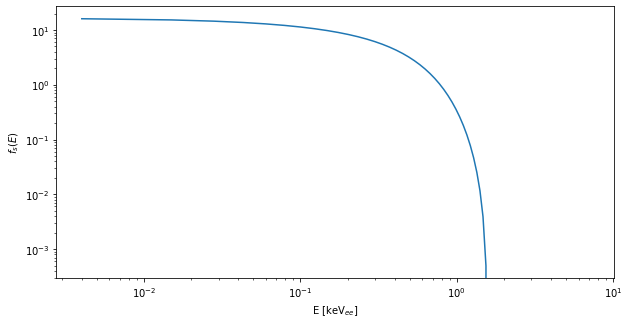

In [231]:
### Normalized pdf signal
E_range = np.linspace(lindhard_inv(0.004),lindhard_inv(7),100)
#dR_s = np.array([dR_dEe(E, N_p_Si, N_n_Si, mass_dm, cross_section) for E in E_range])
dR_s = DMU.dRdE_standard(Enr_space, N_p_Si, N_n_Si, mass_dm, cross_section)
#print("Integral Normalized dRdE: ", quad(dR_dEe, 0, lindhard_inv(7), args = (N_p_Si, N_n_Si, mass_dm, cross_section),epsabs=1e-6)[0]/C_sig)
#print("Integral Normalized dRdE: ", simpson(dRdEe_ev/C_sig, lindhard(Enr_space)) )
print("Integral Normalized dRdE: ", simpson(dR_s/C_sig_theo,Enr_space) )

plt.loglog(lindhard(E_range), dR_s/C_sig_theo)
plt.xlabel(r"E [keV$_{ee}$]")
plt.ylabel(r"$f_s(E)$")
plt.show()

## Inverse transform samplig to simulate the energy distribution of events.

https://en.wikipedia.org/wiki/Inverse_transform_sampling

We need a pdf in our case is $f_s(E|M)$. Now we need to calculate the cumulative distribution function wich is obtained by doing

$$
F_s(E|M) = \int_0^{E} f_s(E'|M) \cdot dE'
$$

Now we simulate a random number $u \in [0,1]$. The random energy of the event that will follow $f_s(E|M)$ is obtained from

$$
E_{event} = F_s^{-1}(u|M)
$$

In [232]:
def cdf_signal(Er, N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection=False):  
    """ Calculates the cumulative distribution function at value Er.
        It calculates it for the theoretical differential rate or the detected.
    """
    ndarr=isinstance(Er, (np.ndarray))
    if ndarr:
        ### Por la cara a veces con random signal llega un ndarray
        Er = Er[0]
        
    if  Er > lindhard_inv(0.004):
        E_space = np.geomspace(lindhard_inv(0.004),Er,100)
        if detection:
            fs = dR_dEe(E_space,N_p_Si, N_n_Si, m_x, sigma_p)/C_sigma0
            cdf = simpson(fs, lindhard(E_space))
        else:
            cdf = simpson(DMU.dRdE_standard(E_space, N_p_Si, N_n_Si, m_x, sigma_p)/C_sigma0, E_space)

    else:
        cdf = 0
    
    cdf = np.array([cdf])
    return cdf


def random_signal(n_size, N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection=False):
    """ Simulates the energy of the events.
        Returns the energy in Nuclear recoil units.
    """

    u = np.random.rand(n_size)
    events = []
    for x in u:
        E_event = float(inversefunc(cdf_signal, y_values = x, args=(N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection)))
        if E_event < 0:
            """ This problem is due to dRdEe is not a continuos function.
                When it reaches the efficiency threshold it fails to calculate the inverse.
                We just recalculate the random number until we obtain E_event>0.
            """
            negative = True
            while negative:
                u_i = np.random.rand(1)
                E_event = float(inversefunc(cdf_signal, y_values = u_i, args=(N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection)))
                if E_event>0:
                    negative = False
        events.append(E_event)

    return events
    

### Theoretical Fit

--- 0.05562138557434082 seconds ---


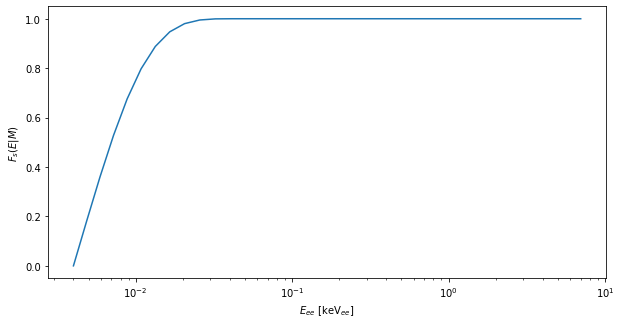

In [233]:
#print(cdf_signal(11,  N_p_Si, N_n_Si, mass_dm, cross_section, s, True))
x_cdf = np.geomspace(lindhard_inv(0.004),lindhard_inv(7),30)
start_time = time.time()
cdf = [cdf_signal(x,  N_p_Si, N_n_Si, mass_dm, cross_section, C_sig_theo, False) for x in x_cdf]
print("--- %s seconds ---" % (time.time() - start_time))
plt.plot(lindhard(x_cdf), cdf)
plt.xlabel(r"$E_{ee}$ [keV$_{ee}$]")
plt.ylabel(r"$F_s(E|M)$")
plt.xscale("log")
plt.show()


In [234]:
start_time = time.time()
signal_events = random_signal(n_det,  N_p_Si, N_n_Si, mass_dm, cross_section, C_sig_theo, False)
print(signal_events)
print("--- %s seconds ---" % (time.time() - start_time))

[0.12667650675819667, 0.10730802324435498, 0.18740196631650521, 0.14564902154605516, 0.13395838828750578, 0.2742804005316168, 0.10272031924943102, 0.1397350322747345, 0.1375208772686022, 0.14637843474807283, 0.16542717540065488, 0.1357473526037916, 0.13054815227087951, 0.17534867991510777, 0.28136007920297845, 0.269888248080888, 0.14704773800098267, 0.14471501026829758, 0.14084135125685532, 0.14884176213551673, 0.11916322433323032, 0.1327019914112072, 0.17240196211564437, 0.1341856734605644, 0.19413189578258, 0.10496375799691027, 0.17150940953992774, 0.10738242734753112, 0.12794463683389584, 0.24525749313711293, 0.22050005275285822, 0.12668125262223545, 0.22473245063387895, 0.16316598515996866, 0.19149442675778622, 0.1810472041331837, 0.1160138606131627, 0.11701197006204395, 0.14921691352676295, 0.2367489150733292, 0.13293254331647045, 0.11698317988522926, 0.1919332898921619, 0.16833449172037282, 0.11887556781984235, 0.21816411123282176, 0.11660955447539961, 0.15612068125093526, 0.3326

Finding the cross section
[-39.23908241]
Cross Section exponent and mass calculated:  -39.23908241152045
Obtained Cross section:  5.766570268379912e-40
Original Cross Section:  6e-40


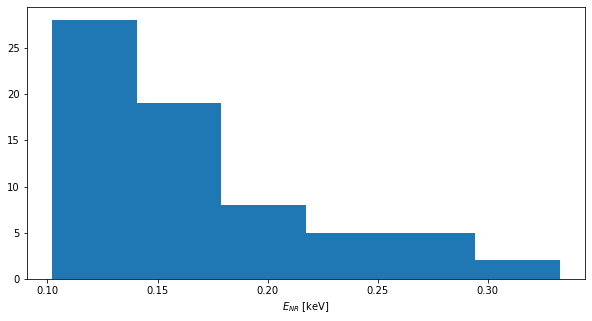

In [235]:
#plt.hist(lindhard(np.array(signal_events)), bins = 10)
plt.hist(np.array(signal_events), bins = 6)

plt.xlabel(r"$E_{NR}$ [keV]")

print("Finding the cross section")

bnds = [(-50,-30)]
theta = minimize(log_likelihood, [-30],bounds=bnds,method='L-BFGS-B', args = (np.array(signal_events), lindhard_inv(4e-3),lindhard_inv(7),N_p_Si, N_n_Si, mass_dm,mass_det*expo_det, False)).x
print(theta)
print("Cross Section exponent and mass calculated: ", theta[0])
print("Obtained Cross section: ", np.power(10,theta[0]))
print("Original Cross Section: ", cross_section)

In [236]:
def random_background(n_size, Ermin, Ermax):
    """ For consistency we give Ermin and Ermax in Enr units.
    """
    if lindhard(Ermin)<0.008:
        Ermin = lindhard_inv(0.008)
    E_bkg = np.random.uniform(lindhard(Ermin), lindhard(Ermax), n_size)
    return lindhard_inv(E_bkg).tolist()


Number of background events:  349.9726170128714
Number of detected background events:  353


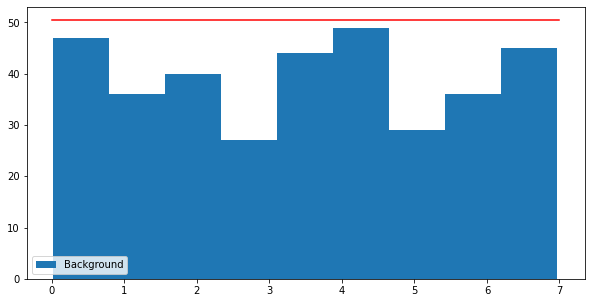

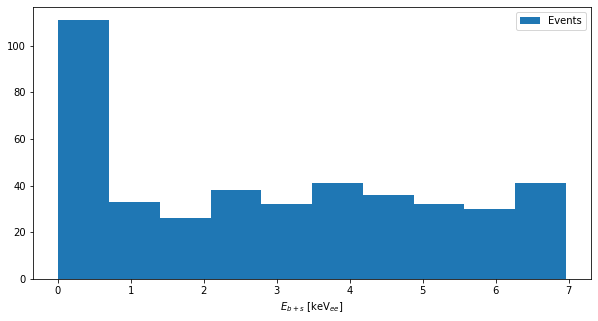

Finding the cross section
Cross Section exponent and expected bkg calculated:  -39.37796768588192 371.34192432196164
Obtained Cross section:  4.188247270339844e-40
Original Cross section:  6e-40


In [237]:
### Expected backgoun 15+-3 events/kg days keV_ee
N = 10
C_b = N*(lindhard(E_range[-1])-lindhard(0.008)) #dRb/dE
b = mass_det*expo_det*C_b
n_b_det = np.random.poisson(b)
print("Number of background events: ", b)
print("Number of detected background events: ", n_b_det)
b_events = random_background(n_b_det, lindhard_inv(4e-3), lindhard_inv(7))
plt.hist(lindhard(np.array(b_events)), bins = int(np.ceil(np.log2(len(b_events)+1)) ), label="Background")
plt.plot(lindhard(E_range),[n_b_det/(7-0.008)]*len(E_range),color="r")
plt.legend(loc="best")
plt.show()
## Total events
events = np.array(signal_events + b_events)

bin_count = int(np.ceil(np.log2(len(events))) + 1)
plt.hist(lindhard(np.array(events)), bins = bin_count, label = "Events")#,histtype='step', linewidth=3,color = "k")
plt.xlabel(r"$E_{b+s}$ [keV$_{ee}$]")

### Plot of expected b+s over events
#expected_s = dR_s*mass_det*expo_det
#plt.plot(lindhard(E_range), expected_s , label = "Expected Detected Signal", color = "g")
#expected_b = np.array([n_b_det/(7-0.008)] * len(E_range))
#plt.plot(lindhard(E_range), expected_b, label = "Expected background", color = "k")
#plt.plot(lindhard(E_range), expected_s +expected_b, label = "Expected Bkg+Signal", color = "r" )
plt.legend(loc="best")
#plt.xlim(0,7)
plt.show()


### Finding cross section b+s
print("Finding the cross section")
bnds = [(-50,-20),[0,1e4]]
theta = minimize(log_likelihood, [-38,1], bounds=bnds,method='L-BFGS-B',args = (events, lindhard_inv(4e-3),lindhard_inv(7),N_p_Si, N_n_Si, mass_dm,mass_det*expo_det,False, True)).x
print("Cross Section exponent and expected bkg calculated: ", theta[0], theta[1])
print("Obtained Cross section: ", np.power(10,theta[0]))
print("Original Cross section: ", cross_section )

# Only Background Log-likelihood

The log-likelihood for background only is obtained from $-ln|L(b,M|E,s=0)|$*

$$
-ln|L(b,M|E,s=0)| = b - N_{events}\cdot ln|b \cdot f_b(E_i|M)|
$$

We will suppose a flat background distribution. The rate of background events is constant

$$
\frac{dR_b}{dE_{ee}} = \frac{C_b}{\Delta E_{ee}}
$$

Where $C_b$ is 

$$
C_b = \int \frac{dR_b}{dE_{ee}}dE_{ee}
$$

But the quantity that we know ($N$) is the expected number of background events per $keV_{ee}\cdot days\cdot kg$. We can obtain $C_b$ by doing

$$
N = C_b/\Delta E_{ee} \rightarrow C_b= N\Delta E_{ee}
$$

The PDF in the fiducial region is given by

$$
f_b(E_{ee}|M) = \frac{1}{\Delta E_{ee}}\theta(E_{ee}>E_{resolution})
$$

Where $\theta$ is the Heaviside step function.

*$b = C_b\cdot t_{expo}\cdot m_{det}$ and $R_{bkg}$ doesn't depend on energy.

In [244]:
def log_likelihood_bkg(b, Enr, Ermin,Ermax):
    """ Log Likelihood with s = 0 and all parameters free.
    """
    #b = C_b*t_exp_mass
    ### Converts list into np array
    if type(Enr) is list:
        Enr = np.array(Enr)
        
    Eresol = 0.008
    if np.sum(Enr[Enr>Eresol])>0:
        dEee = lindhard(Ermax)-lindhard(Ermin)
        fb_eff = len(Enr)*np.log(b/dEee)
        _lnL = b - fb_eff
        return _lnL

    else:
        _lnL = -np.inf
    return _lnL
        
        
bnds_b = [[0,1e6]]
b0 = minimize(log_likelihood_bkg, 1, bounds=bnds_b, method="L-BFGS-B",args = (events, lindhard_inv(4e-3),lindhard_inv(7))).x
print("b0: ", b0)

lnL_b = -log_likelihood_bkg(b0, events,lindhard_inv(4e-3),lindhard_inv(7)) 
lnL_s = -log_likelihood(theta, events,lindhard_inv(4e-3),lindhard_inv(7),N_p_Si, N_n_Si, mass_dm,mass_det*expo_det,False, True)
print("Max Likelihood Background: ", lnL_b)
print("Max Likelihood Signal: ", lnL_s)

#c = np.linspace(30,60,1000)
#plt.plot(c, [log_likelihood_bkg(c_i, events,lindhard_inv(4e-3),lindhard_inv(7)) for c_i in c] )
#deltaLL = -np.log(np.exp(-lnL_b)/np.exp(-lnL_s))
#print("Delta ln-likelihood: ", deltaLL)

deltaLL = lnL_b-lnL_s
print("Delta ln-likelihood: ", deltaLL)
print("DM Discovered!!!!!") if deltaLL > 4.5 else print("95% sure I havent seen DM around:(")

b0:  [419.9999825]
Max Likelihood Background:  [1299.8647878]
Max Likelihood Signal:  868.1131412505968
Delta ln-likelihood:  [431.75164655]
DM Discovered!!!!!


## Detected signal

2.3099743243536808
Number of theoretical events:  3616.8610179268394
Number of expected events:  843.1406283890935
Number of detected events:  833


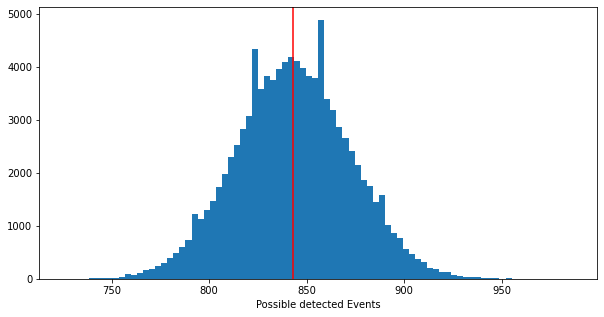

In [245]:
np.random.seed(42)

mass_det = 1 #kg
expo_det = 365 #days
cross_section = 1e-40 #cm2
mass_dm = 10 #GeV
Eemin, Eemax = 4e-3, 7 #keV limits of fiducial region
Ermin, Ermax = lindhard_inv(Eemin) , lindhard_inv(Eemax) 

### Normalization
Enr_space = np.geomspace(Ermin,Ermax,100)
dRdEe_ev = dR_dEe(Enr_space,N_p_Si, N_n_Si,mass_dm, cross_section)
C_sig = simpson(dRdEe_ev, lindhard(Enr_space))
print(C_sig)

### Number of events is mass*expo*integral(dRdE)
s = mass_det*expo_det*C_sig
### Theoretical
C_sig_theo = simpson(DMU.dRdE_standard(Enr_space,N_p_Si, N_n_Si,mass_dm,cross_section),Enr_space)
#print(C_sig_theo)
s_theo = mass_det*expo_det*C_sig_theo

print("Number of theoretical events: ", s_theo)
print("Number of expected events: ", s)
n_det = np.random.poisson(s)
print("Number of detected events: ", n_det)

plt.hist(np.random.poisson(s,100000),bins=84, label="Poisson Dist")
plt.axvline(s, color = "r", label="Detected events")
plt.xlabel("Possible detected Events")
plt.show()

Integral Normalized dRdE:  1.0000000000000002


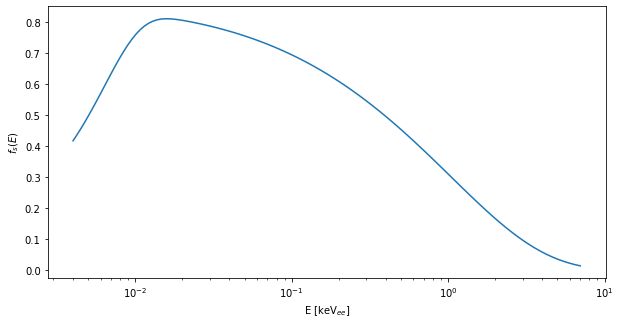

--- 0.09312248229980469 seconds ---


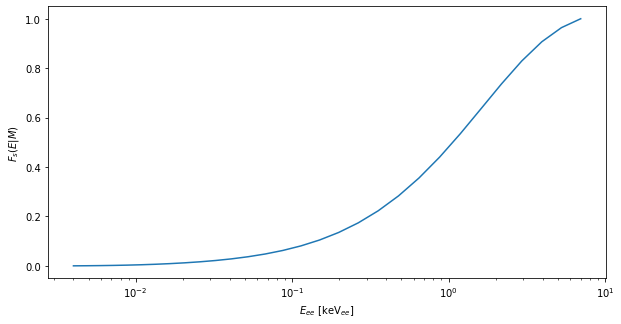

In [246]:
### Normalized pdf signal
E_range = np.geomspace(lindhard_inv(0.004),lindhard_inv(7),100)
dR_s = dR_dEe(E_range, N_p_Si, N_n_Si, mass_dm, cross_section)
print("Integral Normalized dRdE: ", simpson(dR_s/C_sig, lindhard(Enr_space)) )

plt.plot(lindhard(E_range), dR_s/C_sig)
plt.xlabel(r"E [keV$_{ee}$]")
plt.ylabel(r"$f_s(E)$")
plt.xscale("log")
plt.show()

### CDF
start_time = time.time()
cdf = [cdf_signal(x,  N_p_Si, N_n_Si, mass_dm, cross_section, C_sig, True) for x in x_cdf]
print("--- %s seconds ---" % (time.time() - start_time))
plt.plot(lindhard(x_cdf), cdf)
plt.xlabel(r"$E_{ee}$ [keV$_{ee}$]")
plt.ylabel(r"$F_s(E|M)$")
plt.xscale("log")
plt.show()


In [247]:
start_time = time.time()
signal_events = random_signal(n_det,  N_p_Si, N_n_Si, mass_dm, cross_section, C_sig, True)
print(signal_events)
print("--- %s seconds ---" % (time.time() - start_time))

[10.593472389602772, 3.1929502788422504, 3.7449259058846525, 8.229222098397576, 13.808011002840729, 8.601440421769922, 8.36150451216878, 2.145950061274264, 2.91108915752931, 1.4385759826706797, 2.3468881760784717, 4.7224751109735115, 2.684850292456859, 9.807512663084822, 2.1073294596539993, 7.980007235275396, 4.814516045797127, 2.086732012348646, 4.74935114050234, 7.132463048389462, 11.011311714614111, 5.178370805418539, 0.690889724702255, 2.7240320229392303, 9.989418671592231, 4.582860809053608, 6.764661572921962, 2.8064249117218294, 7.892131016640487, 0.7600372718873091, 1.9927466179569284, 5.17270055695901, 1.4179311346341463, 1.787105105662547, 3.9029689120793902, 1.9682370167221155, 8.679811447964843, 0.7815062818607068, 9.785163925745513, 5.96087866948002, 1.1314495622973202, 11.189783479184046, 6.224067313588533, 3.9187493017201667, 4.146865522062693, 9.485000727216564, 4.212933235963658, 5.378009067248031, 12.955642814072636, 3.9481598822130914, 2.2888129701988293, 11.120544623

Finding the cross section
[-40.00525503]
Cross Section exponent and mass calculated:  -40.00525503205393
Cross section:  9.87972754066203e-41
Original Cross section:  1e-40


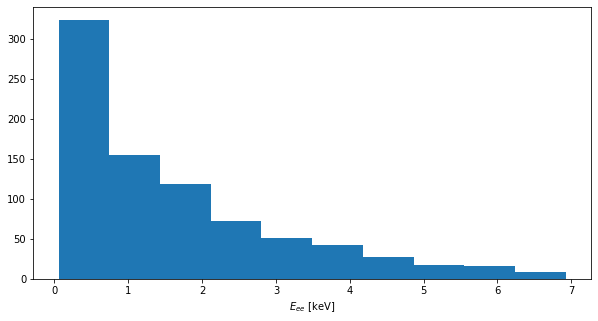

In [248]:
plt.hist(lindhard(np.array(signal_events)), bins = 10)

plt.xlabel(r"$E_{ee}$ [keV]")

print("Finding the cross section")

bnds = [(-50,-30)]
theta = minimize(log_likelihood, [-30],bounds=bnds,method='L-BFGS-B', args = (signal_events, lindhard_inv(4e-3),lindhard_inv(7),N_p_Si, N_n_Si, mass_dm,mass_det*expo_det, True)).x
print(theta)
print("Cross Section exponent and mass calculated: ", theta[0])
print("Cross section: ", np.power(10,theta[0]))
print("Original Cross section: ", cross_section )

Number of background events:  255.48001041939617
Number of detected background events:  262


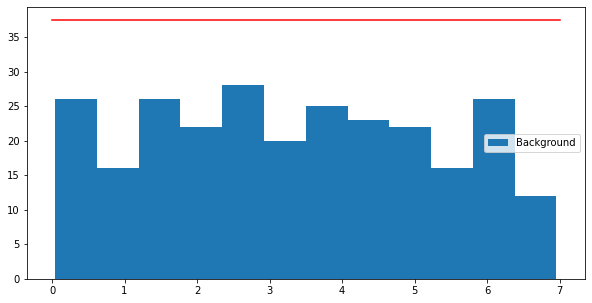

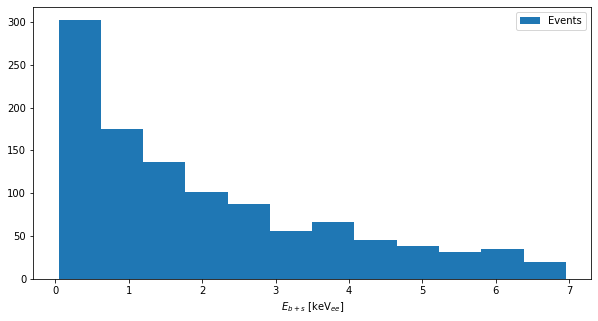

In [255]:
### Expected backgoun 15+-3 events/kg days keV_ee in DAMIC100
N = 0.1
C_b = N*(lindhard(E_range[-1])-lindhard(0.008)) #dRb/dE
b = mass_det*expo_det*C_b
n_b_det = np.random.poisson(b)
print("Number of background events: ", b)
print("Number of detected background events: ", n_b_det)
b_events = random_background(n_b_det, lindhard_inv(4e-3), lindhard_inv(7))
plt.hist(lindhard(np.array(b_events)), bins = bin_count, label="Background")
plt.plot(lindhard(E_range),[n_b_det/(7-0.008)]*len(E_range),color="r")
plt.legend(loc="best")
plt.show()

## Total events
events = signal_events + b_events

bin_count = int(np.ceil(np.log2(len(events))) + 1)
plt.hist(lindhard(np.array(events)), bins = bin_count, label = "Events")#,histtype='step', linewidth=3,color = "k")
plt.xlabel(r"$E_{b+s}$ [keV$_{ee}$]")

plt.legend(loc="best")
#plt.xlim(0,7)
plt.show()


In [256]:
### Finding cross section b+s
print("Finding the cross section")
bnds = [(-50,-20),[0,1e4]]
theta = minimize(log_likelihood, [-35,20], bounds=bnds,method='L-BFGS-B',args = (events, lindhard_inv(4e-3),lindhard_inv(7),N_p_Si, N_n_Si, mass_dm,mass_det*expo_det,True, True)).x
print("Cross Section exponent and expected bkg calculated: ", theta[0], theta[1])
print("Cross section: ", np.power(10,theta[0]))

Finding the cross section
Cross Section exponent and expected bkg calculated:  -40.00209470197345 255.92544425763523
Cross section:  9.951883835548899e-41


In [257]:
bnds_b = [[0,1e6]]
b0 = minimize(log_likelihood_bkg, 20, bounds=bnds_b, method="L-BFGS-B",args = (events, lindhard_inv(4e-3),lindhard_inv(7))).x
print("b0: ", b0)

lnL_b = -log_likelihood_bkg(b0, events, lindhard_inv(4e-3),lindhard_inv(7)) 
lnL_s = -log_likelihood(theta, events, lindhard_inv(4e-3),lindhard_inv(7),N_p_Si, N_n_Si, mass_dm,mass_det*expo_det,False, True)
print("Max Likelihood Background: ", lnL_b)
print("Max Likelihood Signal: ", lnL_s)

#c = np.linspace(30,60,1000)
#plt.plot(c, [log_likelihood_bkg(c_i, events,lindhard_inv(4e-3),lindhard_inv(7)) for c_i in c] )
#deltaLL = -np.log(np.exp(-lnL_b)/np.exp(-lnL_s))
#print("Delta ln-likelihood: ", deltaLL)

deltaLL = lnL_b-lnL_s
print("Delta ln-likelihood: ", deltaLL)
print("DM Discovered!!!!!") if deltaLL > 4.5 else print("95% sure I havent seen DM around:(")

b0:  [1095.06808801]
Max Likelihood Background:  [4438.22234405]
Max Likelihood Signal:  2234.654547768716
Delta ln-likelihood:  [2203.56779628]
DM Discovered!!!!!


# Pruebas

In [ ]:
#x = np.linspace(0,101,100)
#y = x
 
#from scipy.interpolate import UnivariateSpline
#spl = UnivariateSpline(Eee, dR_dE , s=0)
#plt.loglog(Eee[lindhard(Eee)>1e-10],) 
#plt.show()

## EEMCE Confidence region

In [ ]:
### Example

np.random.seed(42)
x = np.linspace(0,100,100)
#yerr = np.array([0.1] * len(x))
yerr = np.random.normal(1,0.2,len(x))
m_true, b_true = 0.5,1
y = m_true*x + b_true + yerr

def log_l(theta,x,y,yerr):
    m,b = theta
    model = m*x+b
    #print((y-model)**2/y_err**2)
    sigma2 = yerr ** 2
    return np.sum((y-model) ** 2 /sigma2)



def log_prior(theta):
    m,b = theta
    if -2 < m < 3 and -1 < b < 5:
        return 0.0
    return -np.inf

def log_lp(theta,x,y,yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - log_l(theta,x,y,yerr)

soln = minimize(log_l, [2,7], args=(x,y,yerr))
print(soln.x)
m,b = soln.x


plt.errorbar(x,y, yerr = yerr,fmt='.',label ="data")
plt.plot(x,m*x+b, label='fit')
plt.show()


pos = soln.x + 1e-4 * np.random.randn(32,2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_lp, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);


fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [ ]:
import corner

tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true]
);


inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, np.dot(np.vander(x, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, m_true * x + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, np.dot(np.vander(x, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, m_true * x + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 95])
    print(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

## Simulating random numbers with custom PDF
https://gist.github.com/amarvutha/c2a3ea9d42d238551c694480019a6ce1


In [ ]:
def gauss(x,mu0,sig):
    return np.exp(-(x-mu0)**2/(2*sig**2))/(np.sqrt(2*np.pi*sig))

def cdf_gauss(x, mu0, sig):
    return quad(gauss, -np.inf, x, args=(mu0,sig),epsabs=1e-6)[0]

x_gaus = np.linspace(-10,10,1000)
y_gaus = gauss(x_gaus, 0, 1)
plt.plot(x_gaus, y_gaus)
plt.show()


x_gaus_cdf = np.linspace(-10,10,1000)
y_gaus_cdf = [cdf_gauss(u,0,1) for u in x_gaus_cdf]
plt.plot(x_gaus_cdf,y_gaus_cdf)
plt.show()

def random_gauss(n_size,mu0,sig):
    u = np.random.uniform(low=4e-3, size=n_size)
    events = [float(inversefunc(cdf_gauss, y_values=x, args=(mu0,sig))) for x in u]
    return events

ev = random_gauss(10000,0,1)
plt.hist(np.random.normal(0,1,10000), bins=100,density = True, alpha = 0.7, label = "NumPy")
plt.hist(ev, bins=100, density = True, alpha = 0.7, label = "Mine")
plt.plot(x_gaus,y_gaus,color = "r", label = "Original")
plt.legend(loc="best")
plt.show()

In [ ]:
class random_signal(rv_continuous):
    def _pdf(self, x, N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection):
        if detection:
            pdf = dR_dEe(x,N_p_Si, N_n_Si, m_x, sigma_p)/C_sigma0
        else:
            pdf = DMU.dRdE_standard(x, N_p_Si, N_n_Si, m_x, sigma_p)/C_sigma0
        return pdf
x = np.linspace(0.0, lindhard_inv(7), 100)

start_time = time.time()
signal_dist = random_signal(name="signal_dist", a=0.0, b=lindhard_inv(7))
#pdf_sig = signal_dist(N_p_Si=N_p_Si, N_n_Si=N_n_Si, m_x=mass_dm, sigma_p=cross_section, C_sigma0=C_sig, detection = True) 
samples = signal_dist.rvs(N_p_Si=N_p_Si, N_n_Si=N_n_Si, m_x=mass_dm, sigma_p=cross_section, C_sigma0=C_sig, detection = True, size=24)
print("--- %s seconds ---" % (time.time() - start_time))
plt.hist(samples, bins = 5)

In [ ]:
def cdf_mc_integral(n_size, Emin, Emax, N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection):
    E_rn = np.random.uniform(Emin, Emax, n_size)
    if detection:
        for E in E_rn:
            pdf_av = [dR_dEe(E, N_p_Si, N_n_Si, m_x, sigma_p)/C_sigma0 for E in E_rn]
    else:
        for E in E_rn:
            pdf_av = [DMU.dRdE_standard(x, N_p_Si, N_n_Si, m_x, sigma_p)/C_sigma0 for E in E_rn]
    return (Emax-Emin)*np.mean(pdf_av)

x = np.linspace(lindhard_inv(0.004), lindhard_inv(7),100)
cdf = [cdf_mc_integral(1000, lindhard_inv(0.004), E, N_p_Si, N_n_Si, mass_dm, cross_section, s, False)   for E in x]
plt.plot(x,cdf)

## Python things

In [ ]:
def hola(a,b,c=True, **kwargs):
    if c:
        return a+b
    else:
        if "Detection" in kwargs:
            print(kwargs["Detection"])
        else:
            print("Hola")
            
            
hola(1,2,True)

In [ ]:
def adios(a,b,*args,c=False):
    if c:
        return a+b
    else:
        if "Detection" in args:
            print(args)
        else:
            print("Hola")
            
            
adios(1,2,["Detection"])